# Функции обратного вызова и события

При работе с дифференциальным уравнением наша система будет развиваться через множество состояний. Нас может интересовать конкретное состояние системы (событие). Например, события могут включать момент, когда наша система достигает определенной температуры или скорости. Мы ***обрабатываем*** эти события с помощью ***обратных вызовов***, которые сообщают нам, что делать после запуска события. 

Однако эти обратные вызовы не ограничиваются просто обработкой событий. Например, мы можем использовать обратные вызовы для достижения высокоуровневого поведения, такого как точное соблюдение законов сохранения и сохранение следа матрицы в заранее определенные моменты времени. Эта дополнительная функциональность позволяет нам использовать систему обратного вызова в качестве системы моддинга для решателей экосистемы DiffEq. 

Это руководство представляет собой введение в систему обратного вызова и обработки событий в DifferentialEquations.jl, документированное на странице [Функции обработки событий и обратного вызова](http://docs.juliadiffeq.org/latest/features/callback_functions.html) на странице документация. Мы также познакомим вас с некоторыми из наиболее часто используемых обратных вызовов в [Callback Library](http://docs.juliadiffeq.org/latest/features/callback_library.html), которая является библиотекой предварительно созданных модов..

## События и непрерывные обратные вызовы 

Обработка событий осуществляется посредством непрерывных обратных вызовов. Обратные вызовы принимают функцию, «условие», которая запускает `affect!()`, когда «условие == 0». Эти обратные вызовы называются «непрерывными», потому что они будут использовать поиск по корню в интерполяции, чтобы найти «точный» момент времени, в который имеет место условие, и применить `affect!()` в этот момент времени.

Будем использовать прыгающий шар как простую систему для объяснения событий и обратных вызовов. Возьмем модель шара Ньютона, падающего к поверхности Земли с постоянным ускорением `g`. В этом случае приращение скорости - `-g`, а положение изменяется со скоростью `v`. Поэтому мы получаем систему ОДУ:

In [1]:
import Pkg
Pkg.add("Plots")
Pkg.add("PyPlot")
Pkg.add("DifferentialEquations")
Pkg.add("ParameterizedFunctions")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100,0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [2]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [4]:
using DifferentialEquations, ParameterizedFunctions

In [52]:
ball! = @ode_def BallBounce begin
  dy =  v
  dv = -g
end g

(::BallBounce{var"###ParameterizedDiffEqFunction#352",var"###ParameterizedTGradFunction#353",var"###ParameterizedJacobianFunction#354",Nothing,Nothing,ODESystem}) (generic function with 1 method)

In [53]:
u0 = [50.0,0.0]
tspan = (0.0,3.0)
p = (9.8)
prob = ODEProblem(ball!,u0,tspan,p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 3.0)
u0: [50.0, 0.0]

In [54]:
sol = solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 7-element Array{Float64,1}:
 0.0
 0.00010203877555101957
 0.0011224265310612151
 0.011326304086163171
 0.11336507963718272
 1.1337528351473782
 3.0
u: 7-element Array{Array{Float64,1},1}:
 [50.0, 0.0]
 [49.99999994898163, -0.0009999800003999914]
 [49.99999382677754, -0.010999780004399906]
 [49.99937140269516, -0.11099778004439904]
 [49.93702695772239, -1.1109777804443903]
 [43.70156209309689, -11.110777784444302]
 [5.900000000000067, -29.39999999999999]

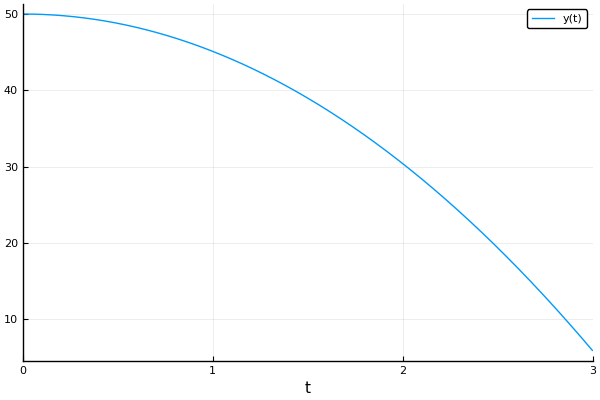

In [55]:
plot(sol,vars=(1))

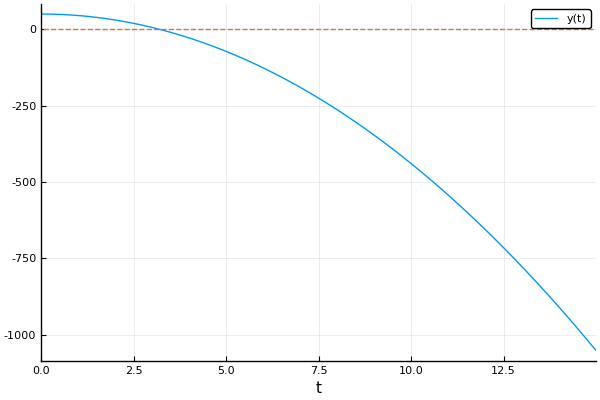

In [58]:
u0 = [50.0,0.0]
tspan = (0.0,15.0)
p = (9.8)
prob = ODEProblem(ball!,u0,tspan,p)
sol = solve(prob,Tsit5())
plot(sol,vars = (1))
hline!([0], line = :dash, label = "")

Мы хотим, чтобы обратный вызов сработал, когда `y = 0`, так как именно тогда мяч попадет на поверхность Земли - это наше событие. Это реализуется с помощью условия:

In [59]:
function condition(u,t,integrator) # Event when event_f(u,t) == 0
  u[1]
end

condition (generic function with 1 method)

Напомним, что `условие` будет срабатывать, когда` u[1] == 0`, что происходит, когда `у == 0`. 
В обратных вызовах используется [интерфейс интегратора](http://docs.juliadiffeq.org/latest/basics/integrator.html). Кратко: 

- Значения записываются в `integrator.u` 
- Время хранится в` integrator.t` 
- Параметры хранятся в `integrator.p` 
- «integrator(t)» выполняет интерполяцию в текущем интервале между «integrator.tprev» и «integrator.t» (и допускает экстраполяцию) 
- Определяемые пользователем параметры (допуски и т.д.) хранятся в «integrator.opts» `
- `integrator.sol` является текущим объектом решения. Обратите внимание, что `integrator.sol.prob` является текущей проблемой

  

Собственно, нашим эффектом будет отскок мяча. Математически говоря, скорости меняет знак, когда мяч отскакивает. В качестве дополнительного поведения, давайте также используем небольшую константу трения, чтобы уменьшить скорость мяча. Таким образом, некоторый процент скорости будет потерян, когда событие инициируется и используется обратный вызов. Мы определим это поведение в функции `affect! `:

In [60]:
function affect!(integrator)
    integrator.u[2] = -integrator.p[2] * integrator.u[2]
end

affect! (generic function with 1 method)

`integrator.u[2]` - это второй параметр нашей модели, который равен `v` или скорости, а` integrator.p[2] `- это наш коэффициент трения. 

Следовательно, `affect! ` можно прочитать следующим образом: `affect! ` примет текущее значение скорости и умножит его на «-1», умноженное на коэффициент трения. Поэтому шар изменит направление, и его скорость будет уменьшена, когда вызывается `affect! `. 

Теперь давайте создадим `ContinuousCallback`:

In [61]:
bounce_cb = ContinuousCallback(condition,affect!)

ContinuousCallback{typeof(condition),typeof(affect!),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT),Float64,Int64,Nothing,Int64}(condition, affect!, affect!, DiffEqBase.INITIALIZE_DEFAULT, nothing, true, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0)

Теперь давайте создадим ODEProblem, который имеет наш обратный вызов:

In [62]:
u0 = [50.0,0.0]
tspan = (0.0,15.0)
p = (9.8,0.9)
prob = ODEProblem(ball!,u0,tspan,p,callback=bounce_cb)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 15.0)
u0: [50.0, 0.0]

Обратите внимание, что мы выбрали постоянную трения «0.9». Теперь мы можем решить проблему и построить решение, как обычно:

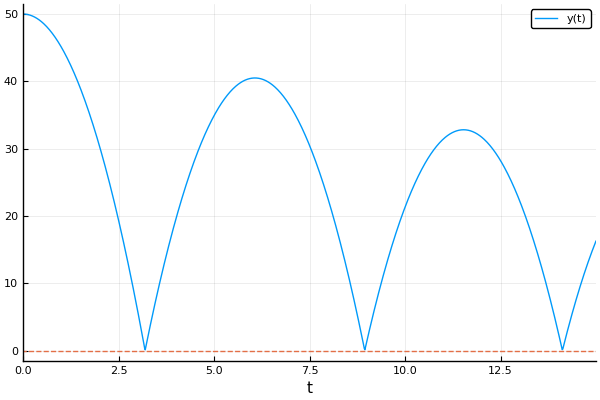

In [63]:
sol = solve(prob,Tsit5())
plot(sol, vars = (1))
hline!([0], line = :dash, label = "")

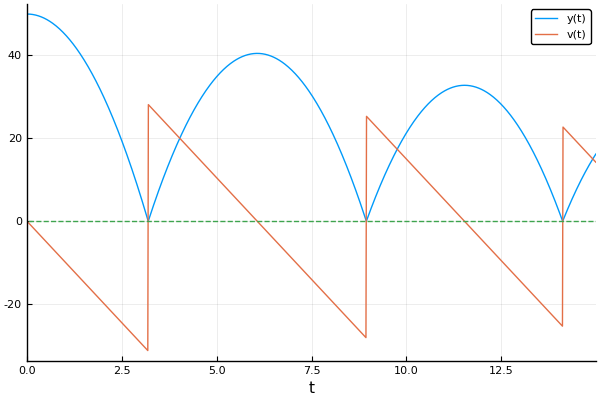

In [64]:
sol = solve(prob,Tsit5())
plot(sol)
hline!([0], line = :dash, label = "")

Мяч отскакивает! Обратите внимание, что ContinuousCallback использует интерполяцию, чтобы применить эффект «точно», когда `v == 0`. Это имеет решающее значение для корректности модели, и поэтому, когда необходимо это свойство, следует использовать `ContinuousCallback`.

#### Упражнение 1 

В нашем примере мы использовали постоянный коэффициент трения, но если мяч прыгает в одном и том же месте, мы можем сгладить поверхность (скажем, раздавить траву), что приведет к уменьшению трения после каждого отскока. В этой более продвинутой модели мы хотим, чтобы коэффициент трения при следующем отскоке составлял `sqrt(трение)` от предыдущего отскока (так как `friction <1`,` sqrt (трение)> трение` и `sqrt (трение) < 1`). 

Подсказка: есть много способов реализовать это. Один из способов состоит в том, чтобы сделать `p` вектором и изменять коэффициент трения в `affect! `.

### Дискретные обратные вызовы 

Дискретный обратный вызов проверяет «условие» после каждого шага интеграции и, если оно истинно, оно будет применять `affect!`. Например, предположим, что в момент времени `t = 2` мы хотим учесть, что ребенок пнул мяч, прибавив 20 к текущей скорости. Такая ситуация, когда мы хотим добавить поведение, после определенного момента времени, является хорошим кандидатом на `DiscreteCallback`. В этом случае `условие` является логическим для того, применять ли `affect!`, Поэтому:

In [ ]:
function condition_kick(u,t,integrator)
    t == 2
end

Мы хотим, чтобы удар произошел при `t = 2`. Когда достигается этот момент времени, происходит вызов:

In [ ]:
function affect_kick!(integrator)
    integrator.u[2] += 20
end

Теперь мы строим проблему, как и раньше:

In [ ]:
kick_cb = DiscreteCallback(condition_kick,affect_kick!)
u0 = [50.0,0.0]
tspan = (0.0,10.0)
p = (9.8,0.9)
prob = ODEProblem(ball!,u0,tspan,p,callback=kick_cb)

Обратите внимание, что, поскольку нам требуется наш эффект именно в момент времени «t = 2», нам нужно указать схеме интегрирования, чтобы она пошла точно до «t = 2», чтобы применить наш обратный вызов. Это делается с помощью опции `tstops`, которая похожа на` saveat`, но означает 'остановиться на этих значениях'.

In [ ]:
sol = solve(prob,Tsit5(),tstops=[2.0])
plot(sol)

Обратите внимание, что этот пример мог быть сделан с помощью `ContinuousCallback` путем проверки условия` t-2`.

## Слияние обратных вызовов в наборы

В некоторых случаях вам может потребоваться объединить обратные вызовы для создания более сложного поведения. В нашем предыдущем результате обратите внимание, что модель нефизична, потому что шар опускается ниже нуля! Что нам действительно нужно сделать, так это добавить отскок обратного вызова вместе с ударом. Это может быть достигнуто через `CallbackSet`.

In [ ]:
cb = CallbackSet(bounce_cb,kick_cb)

CallbackSet объединяет их поведение вместе. Логика заключается в следующем. В заданном интервале, если есть несколько непрерывных обратных вызовов, используется только тот, который запускается в самое раннее время. Время возвращается к тому месту, где запускается этот непрерывный обратный вызов, и затем  вызываются по порядку `DiscreteCallbackи` в наборе обратных вызовов.

In [ ]:
u0 = [50.0,0.0]
tspan = (0.0,15.0)
p = (9.8,0.9)
prob = ODEProblem(ball!,u0,tspan,p,callback=cb)
sol = solve(prob,Tsit5(),tstops=[2.0])
plot(sol)

Обратите внимание, что теперь мы объединили поведение. Затем мы можем вкладывать это так глубоко, как нам нравится.

####  Упражнение 2 

Добавьте к модели линейный ветер с сопротивлением, которое после `t = 10` меняет ускорение на` -g + k * v`. Сделайте это, добавив еще один параметр и оставив его равным нулю до определенного момента времени, когда третий обратный вызов вызывает изменение.

##  Прекращение интеграции и направленная обработка 

Теперь давайте рассмотрим другую модель - модель [Гармонического осциллятора](https://ru.wikipedia.org/wiki/Гармонический_осциллятор). Мы можем задать его так:

In [ ]:
u0 = [1.,0.]
harmonic! = @ode_def HarmonicOscillator begin
   dv = -x
   dx = v
end
tspan = (0.0,10.0)
prob = ODEProblem(harmonic!,u0,tspan)
sol = solve(prob)
plot(sol)

Давайте вместо этого остановим интегрирование при выполнении условия. В [пошаговых элементах управления интерфейса интегратора](http://docs.juliadiffeq.org/latest/basics/integrator.html#Stepping-Controls-1) мы видим, что `terminate! (Интегратор)` приведет к завершению интеграции. Итак, наш новый `affect!`:

In [ ]:
function terminate_affect!(integrator)
    terminate!(integrator)
end

Давайте сначала остановим интегрирование, когда частица вернется к `x = 0`. Это означает, что мы хотим использовать условие:

In [ ]:
function terminate_condition(u,t,integrator)
    u[2]
end
terminate_cb = ContinuousCallback(terminate_condition,terminate_affect!)

Обратите внимание, что вместо добавления обратных вызовов к задаче, мы также можем добавить их в команду `solve`. Это автоматически сформирует `CallbackSet` с любыми обратными вызовами, связанными с проблемами, и, естественно, позволит вам различать функции модели и элементы управления интеграцией.

In [ ]:
sol = solve(prob,callback=terminate_cb)
plot(sol)

Заметьте, что истинное решение гармонического осциллятора здесь - это `sin` и` cos`, и, таким образом, мы ожидаем, что этот возврат к нулю произойдет при `t = π`:

In [ ]:
sol.t[end]

Это один из способов аппроксимировать π! Меньшие погрешности и числа произвольной точности могут сделать это более точным, но давайте без фанатизма. Вместо этого посмотрим, что, если мы хотим остановить интеграцию ровно после одного цикла? Для этого нам нужно игнорировать первый переход через ноль. К счастью, в таких сценариях обычно существует структура проблемы, которую можно использовать. Здесь мы хотим запускать `affect!` только при переходе с положительного на отрицательный, а не при переходе с отрицательного на положительный. Другими словами, мы хотим, чтобы наш `affect!` происходил только при второй смене знака. 

Если конструктору ContinuousCallback дан один `affect!`, он будет отрабатывать при всех пересечениях. Если даны два эффекта, (первый предназначен для пересечении на спуске, а второй - на подъёме) первый можно будет игнорировать, используя `nothing`.

In [ ]:
terminate_upcrossing_cb = ContinuousCallback(terminate_condition,terminate_affect!,nothing)

Что даст

In [ ]:
sol = solve(prob,callback=terminate_upcrossing_cb)
plot(sol)

## Библиотека обратного вызова

Как вы можете видеть, обратные вызовы могут быть очень полезными, и с помощью CallbackSets мы можем объединять различные варианты поведения. Благодаря этой утилите существует библиотека предварительно созданных обратных вызовов, известная как [Библиотека обратных вызовов](http://docs.juliadiffeq.org/latest/features/callback_library.html). Мы рассмотрим несколько примеров, где эти обратные вызовы могут пригодиться.

###       Коллекторная проекция 

Один обратный вызов - это коллекторный обратный вызов. По сути, вы можете определить любое многообразие `g(sol) = 0`, на котором должно жить решение, и заставить интеграцию проецироваться на это многообразие после каждого шага. В качестве примера, давайте посмотрим, что произойдет, если мы наивно запустим гармонический генератор в течение длительного времени:

In [ ]:
tspan = (0.0,10000.0)
prob = ODEProblem(harmonic!,u0,tspan)
sol = solve(prob)
gr(fmt=:png) # Make it a PNG instead of an SVG since there's a lot of points!
plot(sol,vars=(1,2))

In [ ]:
plot(sol,vars=(0,1),denseplot=false)

Обратите внимание, что происходит отклонение численного решения от истинного решения в течение этого длительного периода времени. Это потому, что интегратор не учитывает сохранение энергии.

In [ ]:
plot(sol.t,[u[2]^2 + u[1]^2 for u in sol.u]) # Energy ~ x^2 + v^2

Некоторые техники интегрирования, такие как [симплектические интеграторы](http://docs.juliadiffeq.org/latest/solvers/dynamical_solve.html#Symplectic-Integrators-1), предназначены для смягчения этой проблемы, но вместо этого давайте решим нашу проблему путем принудительного сохранения энергии. Для этого мы определим наше многообразие, в котором энергия равна 1 (поскольку это выполняется в начальном состоянии), то есть:

In [ ]:
function g(resid,u,p,t)
  resid[1] = u[2]^2 + u[1]^2 - 1
  resid[2] = 0
end

Здесь первый показатель показывает, насколько мы ннеукладываемся в энергетический баланс, а количество условий соответствует размеру нашей системы (мы проигнорировали второе, сделав остаток 0). Таким образом, мы определяем обратный вызов ManifoldProjection и добавляем его в решатель:

In [ ]:
cb = ManifoldProjection(g)
sol = solve(prob,callback=cb)
plot(sol,vars=(1,2))

In [ ]:
plot(sol,vars=(0,1),denseplot=false)

Теперь у нас есть «идеальное» энергосбережение, при котором, если оно когда-либо будет нарушено слишком сильно, решение вернется обратно к «энергии = 1».

In [ ]:
u1,u2 = sol[500]
u2^2 + u1^2

Хотя выбор различных схем интеграции и использование более низких допусков также позволяет достичь этого эффекта, это может быть хорошим способом обеспечения физических ограничений и, таким образом, используется во многих дисциплинах, таких как молекулярная динамика. Другим таким ограничивающим обратный вызов домена является [`PositiveCallback ()`](http://docs.juliadiffeq.org/latest/features/callback_library.html#PositiveDomain-1), который можно использовать для обеспечения положительности переменных.

###       SavingCallback 

`SavingCallback` может использоваться для обеспечения особого поведения при сохранении. Давайте возьмем линейное определение ODE для системы матриц 1000x1000:

In [ ]:
using LinearAlgebra

In [ ]:
prob = ODEProblem((du,u,p,t)->du.=u,rand(1000,1000),(0.0,1.0))

В таких областях, как квантовая механика, вы можете узнать только конкретные свойства решения, такие как след или норма матрицы. Сохранение всех матриц 1000x1000 может быть дорогостоящим способом получения этой информации! Вместо этого мы можем использовать `SavingCallback` для сохранения` trace` и `norm` в указанное время. Для этого мы сначала определим наш кэш `SavedValues`. Время как всегда `Float64`, и мы хотим сохранить кортежи` Float64` (один для `trace` и один для` norm`), и, таким образом, мы генерируем кеш как:

In [ ]:
saved_values = SavedValues(Float64, Tuple{Float64,Float64})

Теперь мы определяем `SavingCallback`, давая ему функцию` (u, p, t, интегратор) `, которая возвращает значения для сохранения и кеш:

In [ ]:
cb = SavingCallback((u,t,integrator)->(tr(u),norm(u)), saved_values)

Здесь мы берем `u` и сохраняем` (trace (u), norm (u)) `. Когда мы решаем с этим обратным вызовом:

In [ ]:
sol = solve(prob, Tsit5(), callback=cb, save_everystep=false, save_start=false, save_end = false) # Turn off normal saving

Наши значения хранятся в нашей переменной `save_values`:

In [ ]:
saved_values.t

In [ ]:
saved_values.saveval

По умолчанию это происходит только на этапах решателя. Но `SavingCallback` имеет те же элементы управления, что и интегратор. Например, если мы хотим сохранять каждые 0.1 секунды, мы можем сделать это, используя saveat:

In [ ]:
saved_values = SavedValues(Float64, Tuple{Float64,Float64}) # New cache
cb = SavingCallback((u,t,integrator)->(tr(u),norm(u)), saved_values, saveat = 0.0:0.1:1.0)
sol = solve(prob, Tsit5(), callback=cb, save_everystep=false, save_start=false, save_end = false) # Turn off normal saving

In [ ]:
saved_values.t

In [ ]:
saved_values.saveval

####       Упражнение 3 

Вернитесь к гармоническому осциллятору. Используйте `SavingCallback`, чтобы сохранить массив для энергии с течением времени, и делайте это как с, так и без` ManifoldProjection`. Составьте график результатов, чтобы увидеть разницу в проекции.